<a href="https://colab.research.google.com/github/glucard/Leaves-dataset/blob/dev/Binary_clf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np

import os
import tensorflow as tf

# parace que tem que abrir o link com o navegador primeiro para que o download pelo colab funcione.
_URL = 'https://github.com/glucard/Leaves-dataset/archive/refs/heads/dev.zip'
path_to_zip = tf.keras.utils.get_file('Leaves-dataset-dev.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'Leaves-dataset-dev')

leaves_dataset_dir = os.path.join(PATH, 'data')
BATCH_SIZE = 30
IMG_SIZE = (244, 244)

leaves_dataset = tf.keras.utils.image_dataset_from_directory(leaves_dataset_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=IMG_SIZE,
                                                            crop_to_aspect_ratio=False,
                                                             )
leaves_dataset.class_names

Found 602 files belonging to 11 classes.


['acai',
 'aralia_redonda',
 'ata',
 'banana',
 'buriti',
 'cupuacu',
 'hibisco',
 'jabuticaba',
 'laranja',
 'mandioca',
 'manga']

In [52]:
class_index_to_clf = 1 # classe to binary classifier.
class_name = leaves_dataset.class_names[class_index_to_clf]
class_names = [f'not {class_name}', class_name]

labels_ixs = [i for i in range(len(leaves_dataset.class_names))]
new_labels_ixs = [1 * (i == class_index_to_clf) for i in labels_ixs]
# labels_ixs, new_labels_ixs = np.asarray(labels_ixs, dtype=np.int64), np.asarray(new_labels_ixs, dtype=np.int64)

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(labels_ixs, dtype=tf.int32),
        values=tf.constant(new_labels_ixs,  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)


def binary_label(image, label):
  label = table.lookup(label)
  return image, label

binary_leaves_dataset = leaves_dataset.map(binary_label)

In [53]:
leaves_dataset_lenght = leaves_dataset.cardinality().numpy()

train_dataset = binary_leaves_dataset.take(leaves_dataset_lenght//4 * 3)
#train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

validation_dataset = binary_leaves_dataset.skip(leaves_dataset_lenght//4 *3)
#validation_dataset = leaves_dataset.unbatch().batch(BATCH_SIZE)

In [54]:
def image_standardization(image,label):
  """image = tf.image.per_image_standardization(image)"""
  image = tf.math.subtract(image, tf.math.reduce_mean(image))
  return image, label

train_dataset = train_dataset.map(image_standardization)
validation_dataset = validation_dataset.map(image_standardization)

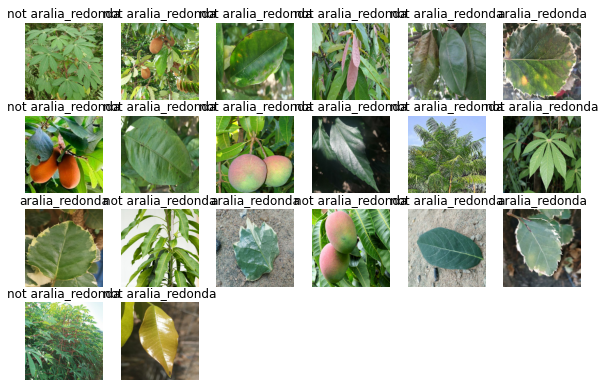

In [55]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(6, 6, i + 1)
    img = tf.keras.utils.array_to_img(images[i].numpy())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)

<MapDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)


In [57]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)
test_dataset = validation_dataset.take(val_batches // 2) # lenght//5 first elements in test_dataset
# validation_dataset = validation_dataset.skip(val_batches // 2) # skipping elements used in test_dataset

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

<MapDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)
Number of validation batches: 6
Number of test batches: 3


In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

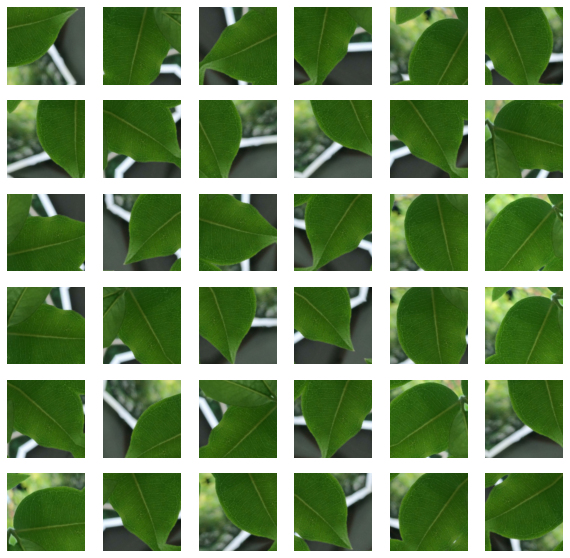

In [59]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(150, 150),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True) # tf.expand_dims() é só pro sample ser tratado como um batch (160,160,3) -> (1,160,160,3)
    
    img = tf.keras.utils.array_to_img(augmented_image[0])

    plt.imshow(img)
    plt.axis('off')

# corrigir bug data_augmentation not working:
# https://stackoverflow.com/questions/71164259/tensorflow-augmentation-layers-not-working-after-importing-from-tf-keras-applica

In [60]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [61]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
# base_model.summary()

(244, 244, 3)


In [62]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset)) # next(iter()) parece uma fila.
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 8, 8, 960)


In [63]:
base_model.trainable = False

In [64]:
conv2_layer_0 = tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )
conv2_layer_1 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )



# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()

hidden_layer_0 = tf.keras.layers.Dense(32, activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-2),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2)
                                         )
prediction_layer = tf.keras.layers.Dense(11, activation='softmax') # não esquecer de trocar numero de classes ao alterar o dataset ou colocar a propria dimensão de classes do dataset

# adicionar mais camada de conv e é isso
"""hidden_batch = hidden_layer(feature_batch_average)
hidden_batch_1 = hidden_layer_1(hidden_batch)
hidden_batch_2 = hidden_layer_2(hidden_batch_1)
hidden_batch_3 = hidden_layer_3(hidden_batch_2)
hidden_batch_4 = hidden_layer_4(hidden_batch_3)
hidden_batch_5 = hidden_layer_5(hidden_batch_4)
hidden_batch_6 = hidden_layer_6(hidden_batch_5)
prediction_batch = prediction_layer(hidden_batch_6)"""

conv2_batch_0 = conv2_layer_0(feature_batch)
conv2_batch_1 = conv2_layer_1(conv2_batch_0)
# feature_batch_average = global_average_layer(conv2_batch_1)
flatten_batch = flatten_layer(conv2_batch_1)
hidden_batch_0 = hidden_layer_0(flatten_batch)
prediction_batch = prediction_layer(hidden_batch_0)

print(prediction_batch.shape)

(30, 11)


In [65]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = conv2_layer_0(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = conv2_layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = global_average_layer(x)
x = flatten_layer(x)
"""
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer_1(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer_2(x)
x = hidden_layer_3(x)
x = hidden_layer_4(x)
x = hidden_layer_5(x)
x = hidden_layer_6(x)
"""
x = hidden_layer_0(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [66]:
base_learning_rate = 0.0017
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 16)          61456     
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 16)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 8)           1160      
                                                           

In [67]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 11s 877ms/step - loss: 9.8882 - accuracy: 0.0066
initial loss: 9.89
initial accuracy: 0.01


In [68]:
print(model.evaluate(test_dataset))

3/3 [==============================] - 6s 1s/step - loss: 10.0622 - accuracy: 0.0000e+00
[10.062172889709473, 0.0]


In [69]:
initial_epochs = 35

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/35
15/15 [==============================] - 37s 2s/step - loss: 6.5538 - accuracy: 0.6867 - val_loss: 5.5619 - val_accuracy: 0.8947
Epoch 2/35
15/15 [==============================] - 31s 2s/step - loss: 5.1102 - accuracy: 0.8756 - val_loss: 4.6634 - val_accuracy: 0.8553
Epoch 3/35
15/15 [==============================] - 31s 2s/step - loss: 4.2294 - accuracy: 0.8756 - val_loss: 3.8077 - val_accuracy: 0.8684
Epoch 4/35
15/15 [==============================] - 29s 2s/step - loss: 3.4466 - accuracy: 0.8956 - val_loss: 3.0403 - val_accuracy: 0.9013
Epoch 5/35
15/15 [==============================] - 29s 2s/step - loss: 2.7516 - accuracy: 0.9133 - val_loss: 2.4360 - val_accuracy: 0.9013
Epoch 6/35
15/15 [==============================] - 29s 2s/step - loss: 2.1656 - accuracy: 0.9333 - val_loss: 1.9004 - val_accuracy: 0.9276
Epoch 7/35
15/15 [==============================] - 29s 2s/step - loss: 1.7123 - accuracy: 0.9600 - val_loss: 1.4788 - val_accuracy: 0.9539
Epoch 8/35
15/15 [==

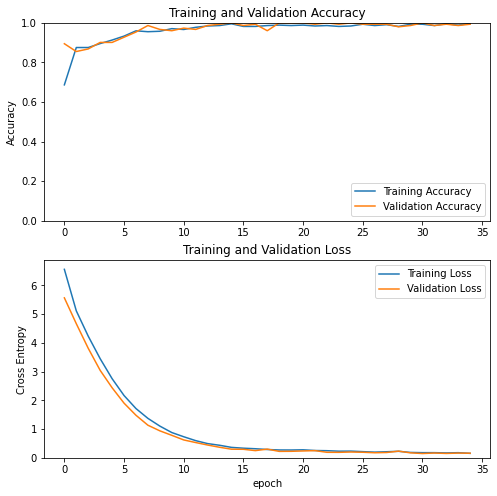

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [71]:
model.evaluate(test_dataset)

3/3 [==============================] - 6s 1s/step - loss: 0.1998 - accuracy: 0.9778


[0.1998426616191864, 0.9777777791023254]

In [72]:
from sklearn.metrics import classification_report
for images, labels in test_dataset.unbatch().batch(616).take(1):
  y_pred = np.argmax(model.predict(images), axis=1)
  print(classification_report(labels.numpy(), y_pred, target_names=class_names))

3/3 [==============================] - 6s 1s/step
                    precision    recall  f1-score   support

not aralia_redonda       1.00      1.00      1.00        82
    aralia_redonda       1.00      1.00      1.00         8

          accuracy                           1.00        90
         macro avg       1.00      1.00      1.00        90
      weighted avg       1.00      1.00      1.00        90



tf.Tensor(
[[[ 18.821121    31.047134    22.021332  ]
  [ -4.9305573    6.467453    -3.8335419 ]
  [-43.540062   -33.89749    -46.439552  ]
  ...
  [ 63.750717    58.750717    28.750717  ]
  [ 47.526794    43.526794    14.526794  ]
  [ 49.640015    45.640015    16.640015  ]]

 [[ 19.33818     28.190643    16.44838   ]
  [ 31.28122     38.98613     27.1678    ]
  [-45.911194   -39.589775   -52.143925  ]
  ...
  [ 51.293854    46.077515    17.726532  ]
  [ 46.042145    42.042145    15.042145  ]
  [ 53.42488     49.42488     23.02687   ]]

 [[ 24.637558    28.768707    12.899857  ]
  [  6.7660294   10.4645      -5.404358  ]
  [-61.38742    -57.857185   -72.48013   ]
  ...
  [ 53.045       48.575226    22.279877  ]
  [ 49.262604    44.63965     21.5085    ]
  [ 42.29573     37.474976    15.59082   ]]

 ...

 [[  0.5753784   -2.3131027  -25.016945  ]
  [ 28.666458    27.240234     5.387764  ]
  [ -0.28513336  -0.1209259  -21.120926  ]
  ...
  [ 22.961685    24.114883     4.2460175 ]
  [ 14.

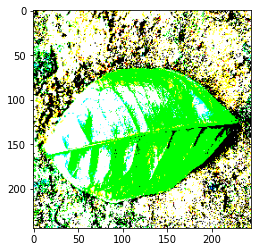

In [73]:
from numpy import expand_dims

np.set_printoptions(suppress=True)
for imgs in test_dataset.take(1):
  img = imgs[0][0]
print(img)
plt.imshow(img)

img = expand_dims(img, axis=0)

In [79]:
ixs = []
for i in range(len(base_model.layers)):
  layer = base_model.layers[i]
  # check for convolutional layer
  if 'project/BatchNorm' not in layer.name or 'conv'.upper() not in layer.name.upper() or layer.output.shape[1:3] == (1,1):
    continue
  # summarize output shape
  
  ixs.append(i)
  print(i, layer.name, layer.output.shape)
print(len(ixs))

#ixs = [12, len(base_model.layers)-1]
ixs.append(len(base_model.layers)-1)

12 expanded_conv/project/BatchNorm (None, 122, 122, 16)
22 expanded_conv_1/project/BatchNorm (None, 61, 61, 24)
30 expanded_conv_2/project/BatchNorm (None, 61, 61, 24)
48 expanded_conv_3/project/BatchNorm (None, 31, 31, 40)
64 expanded_conv_4/project/BatchNorm (None, 31, 31, 40)
81 expanded_conv_5/project/BatchNorm (None, 31, 31, 40)
97 expanded_conv_6/project/BatchNorm (None, 16, 16, 80)
111 expanded_conv_7/project/BatchNorm (None, 16, 16, 80)
126 expanded_conv_8/project/BatchNorm (None, 16, 16, 80)
141 expanded_conv_9/project/BatchNorm (None, 16, 16, 80)
164 expanded_conv_10/project/BatchNorm (None, 16, 16, 112)
186 expanded_conv_11/project/BatchNorm (None, 16, 16, 112)
210 expanded_conv_12/project/BatchNorm (None, 8, 8, 160)
232 expanded_conv_13/project/BatchNorm (None, 8, 8, 160)
255 expanded_conv_14/project/BatchNorm (None, 8, 8, 160)
15


1/1 [==============================] - 1s 1s/step
(1, 122, 122, 16)


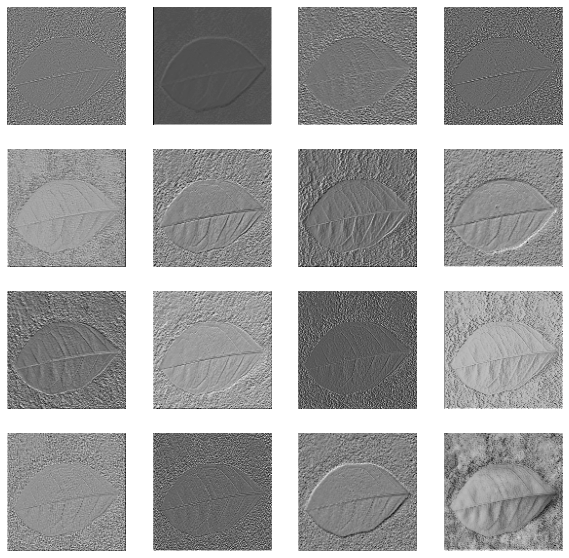

(1, 61, 61, 24)


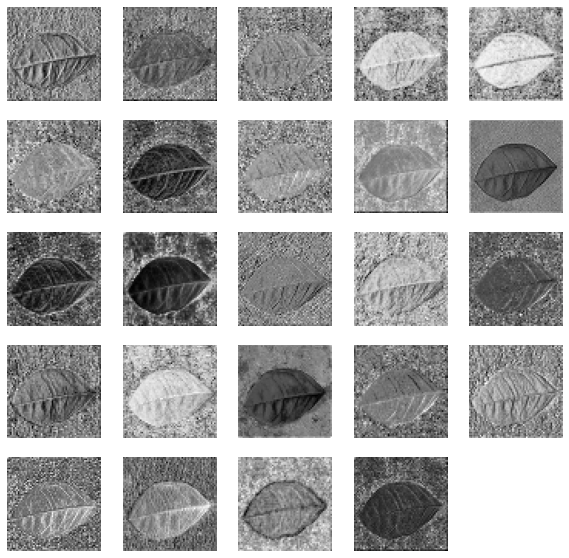

(1, 61, 61, 24)


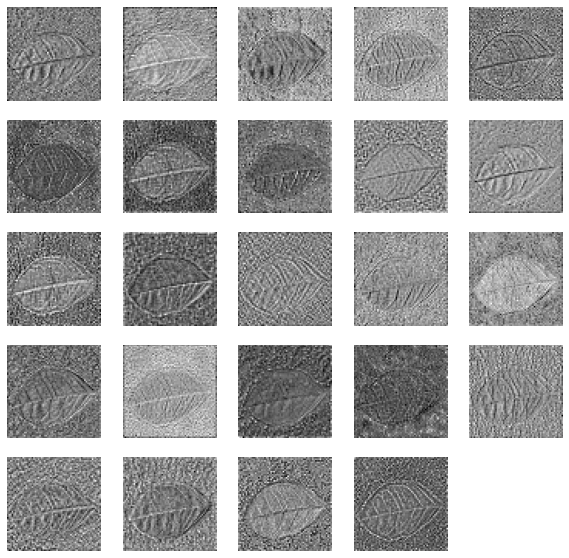

(1, 31, 31, 40)


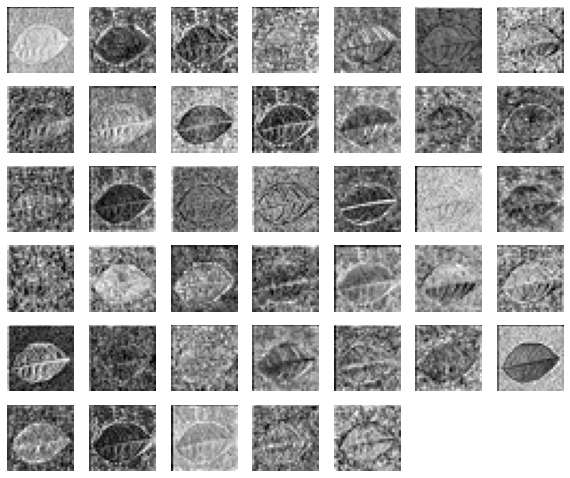

(1, 31, 31, 40)


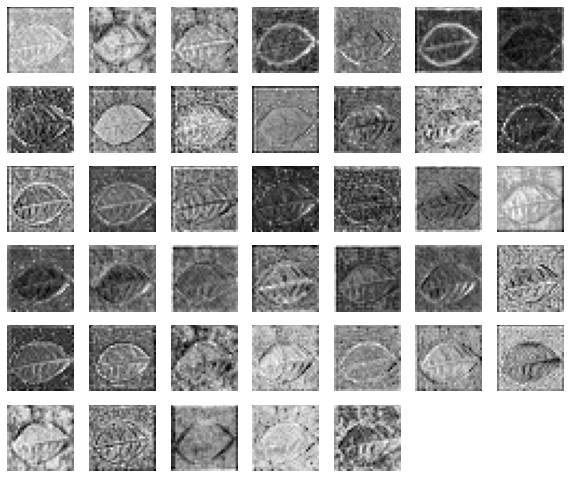

(1, 31, 31, 40)


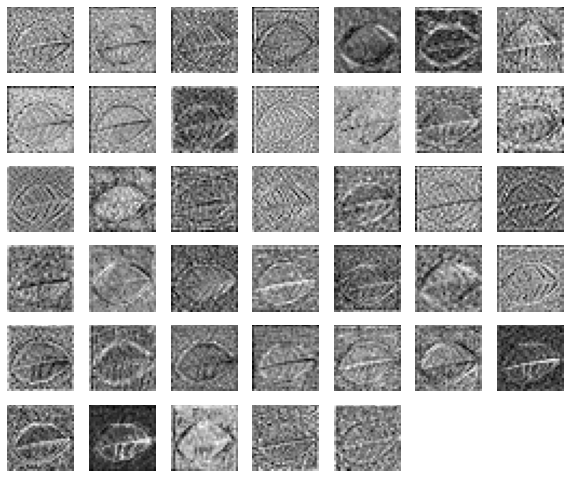

(1, 16, 16, 80)


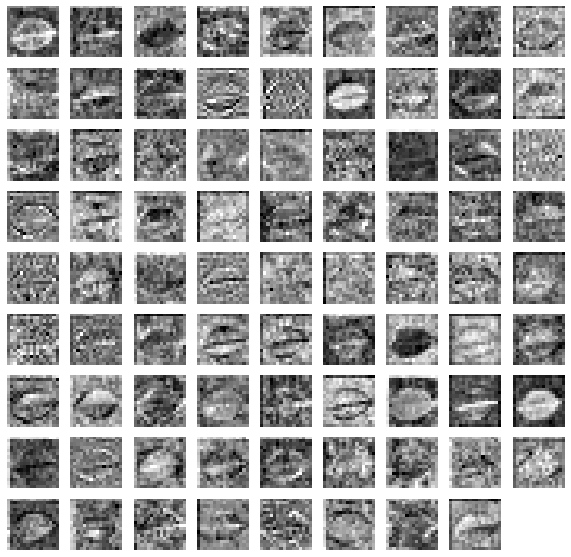

(1, 16, 16, 80)


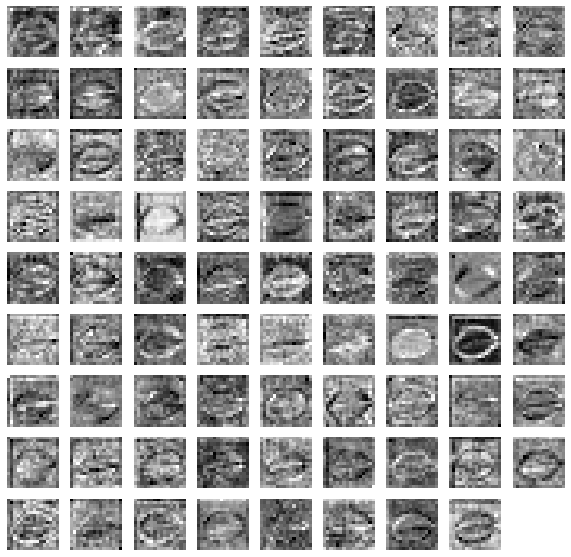

(1, 16, 16, 80)


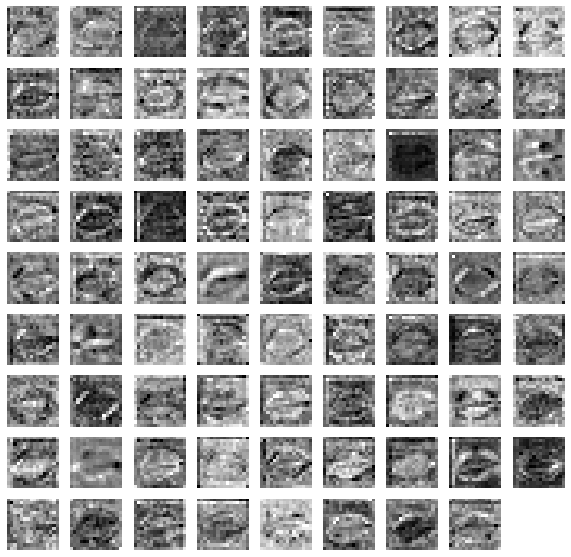

(1, 16, 16, 80)


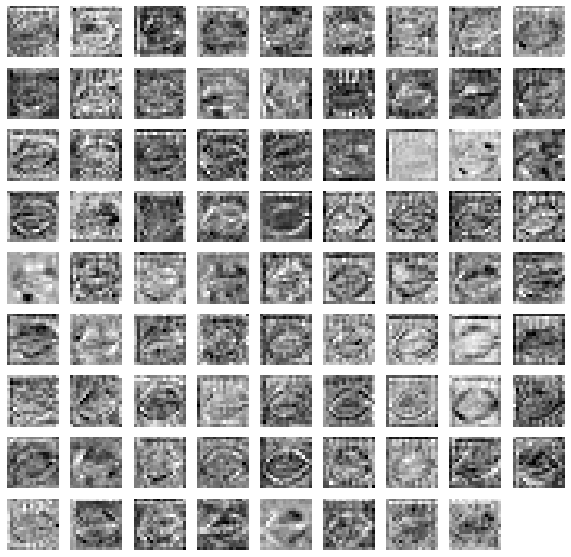

(1, 16, 16, 112)


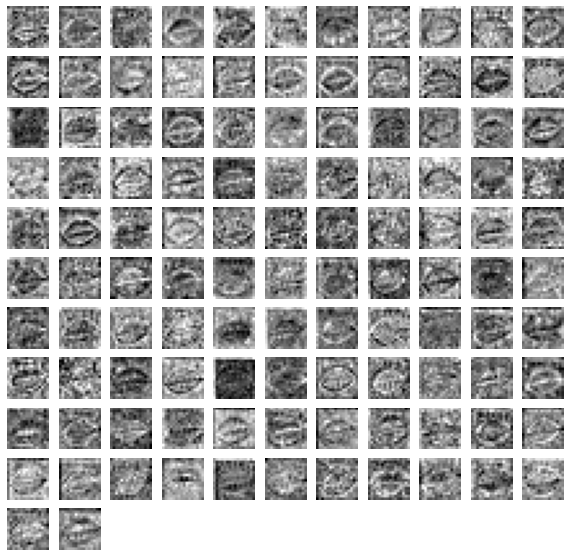

(1, 16, 16, 112)


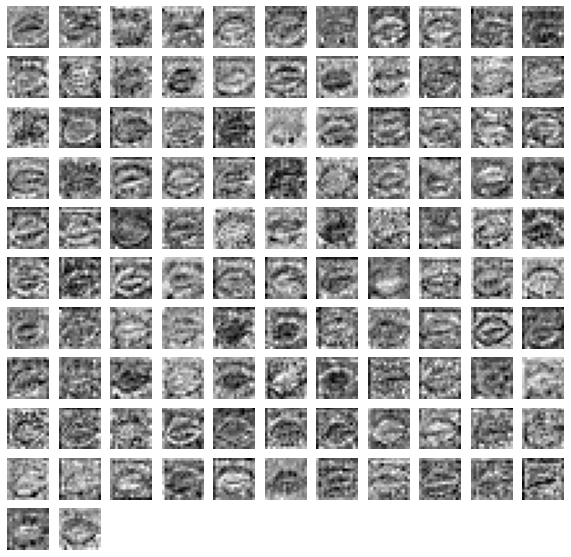

(1, 8, 8, 160)


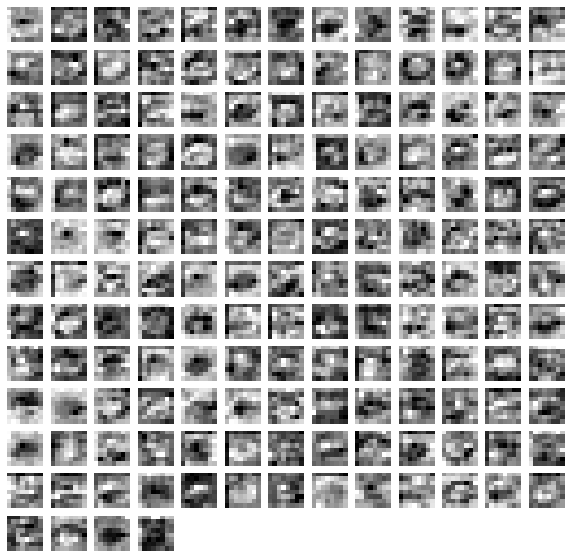

(1, 8, 8, 160)


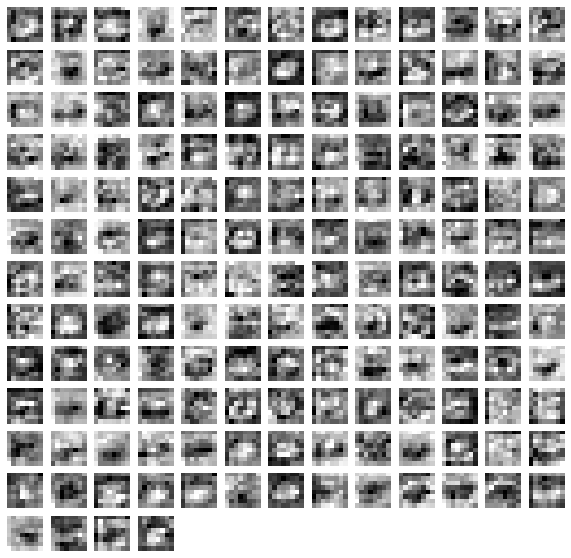

(1, 8, 8, 160)


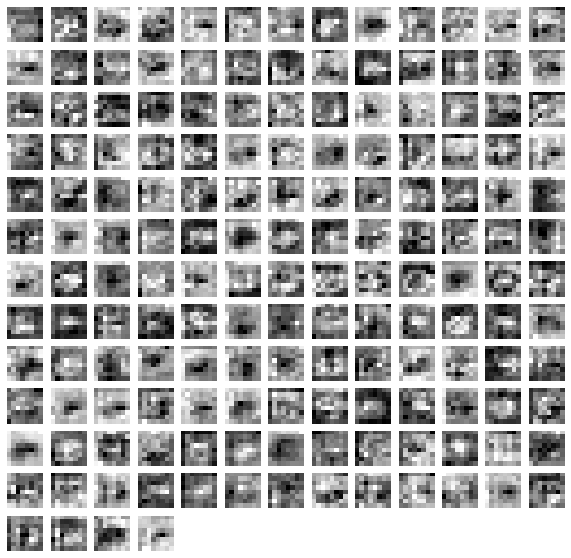

(1, 8, 8, 960)


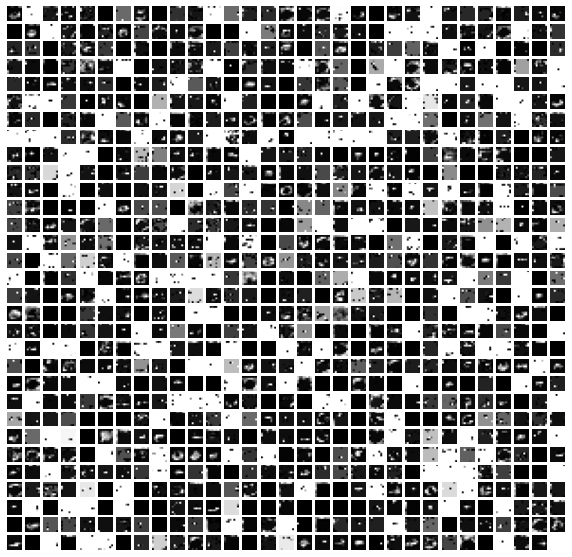

In [80]:
from tensorflow.keras.models import Model
from matplotlib import pyplot

outputs = [base_model.layers[i].output for i in ixs]
model_f = Model(inputs=base_model.inputs, outputs=outputs)

feature_maps = model_f.predict(img)

for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])

  if not square.is_integer():
    square = int(square) + 1

  pyplot.figure(figsize=(10, 10))

  for _ in range(fmap.shape[3]):
      ax = pyplot.subplot(square, square, ix)
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      pyplot.axis('off')
  pyplot.show()

In [76]:
ixs = []
for i in range(len(model.layers)):
  layer = model.layers[i]
  # check for convolutional layer
  if 'conv'.upper() not in layer.name.upper():
    continue
    
  # summarize output shape
  ixs.append(i)
  print(i, layer.name, layer.output.shape)

3 conv2d_4 (None, 7, 7, 16)
5 conv2d_5 (None, 5, 5, 8)


1/1 [==============================] - 1s 1s/step
(1, 7, 7, 16)


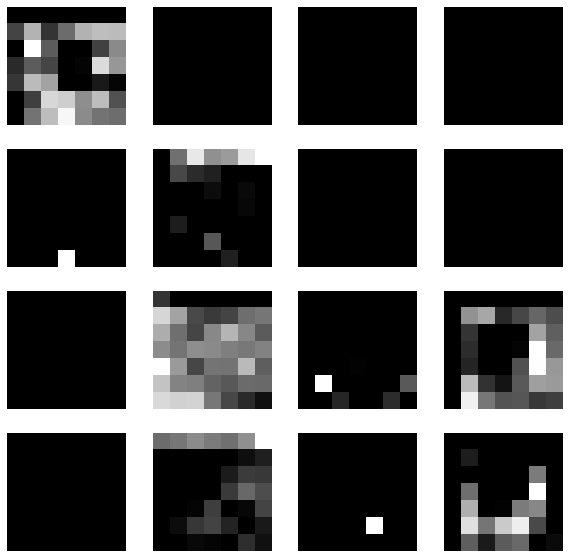

(1, 5, 5, 8)


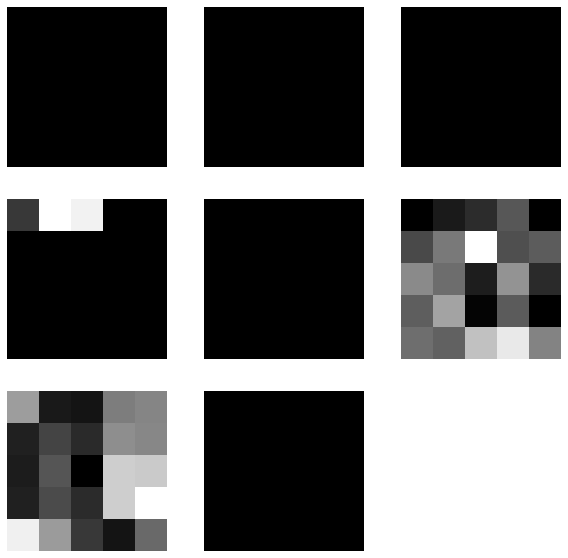

In [77]:
outputs = [model.layers[i].output for i in ixs]
model_f = Model(inputs=model.inputs, outputs=outputs)

feature_maps = model_f.predict(img)

for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])
  if not square.is_integer():
    square = int(square) + 1
  pyplot.figure(figsize=(10, 10))
  for _ in range(fmap.shape[3]):
      ax = pyplot.subplot(square, square, ix)
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      pyplot.axis('off')
  pyplot.show()